In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [7]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test-full.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

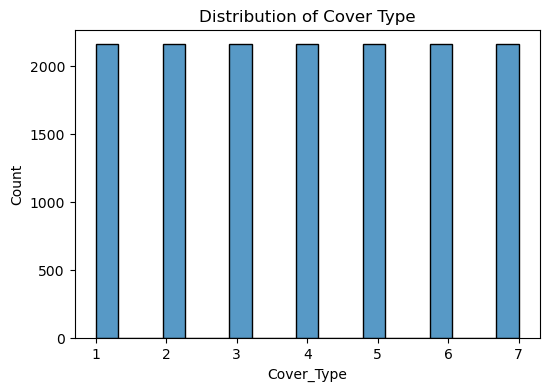

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: count, dtype: int64


In [9]:
plt.figure(figsize=(6, 4))
sns.histplot(data=train, x='Cover_Type')
plt.title('Distribution of Cover Type')
plt.show()

print(train['Cover_Type'].value_counts())

Evenly distributed

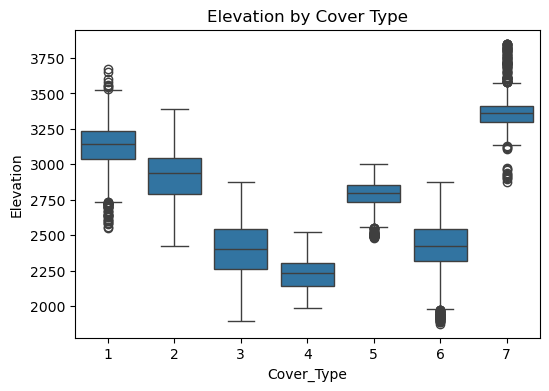

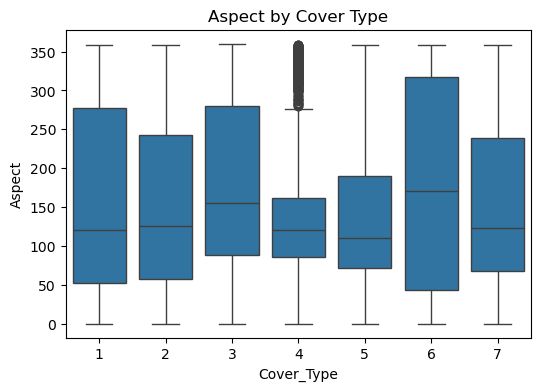

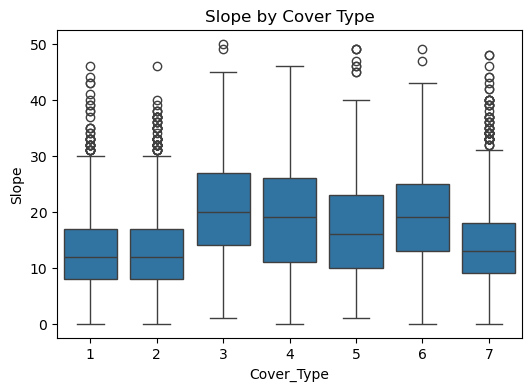

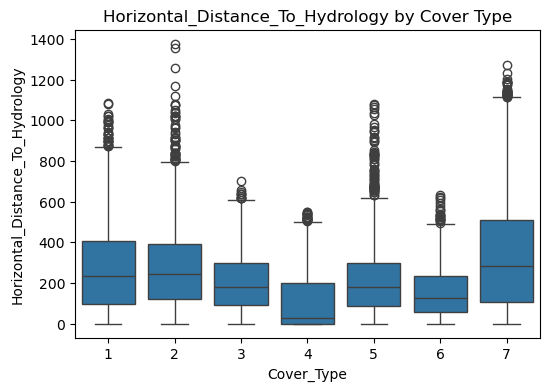

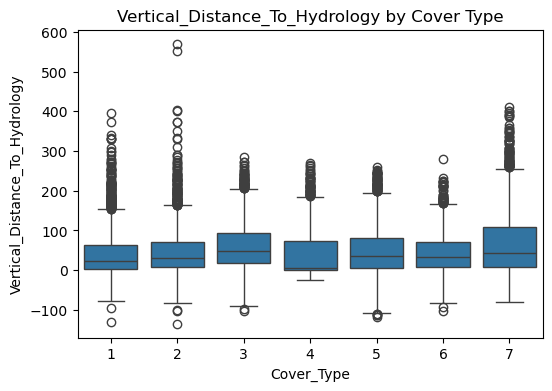

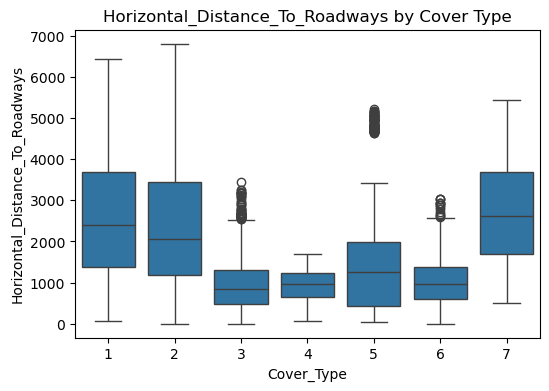

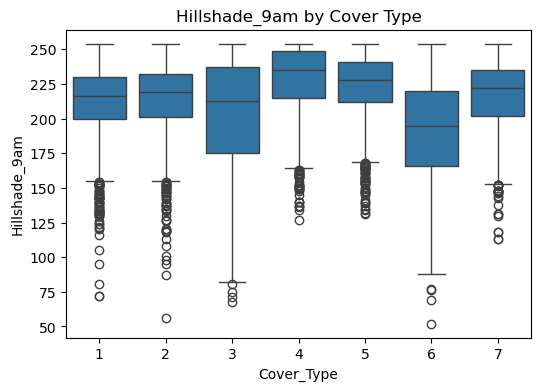

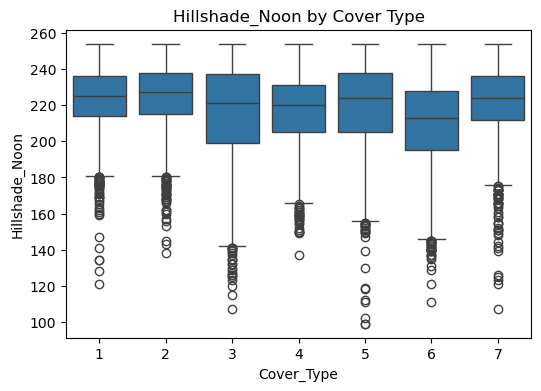

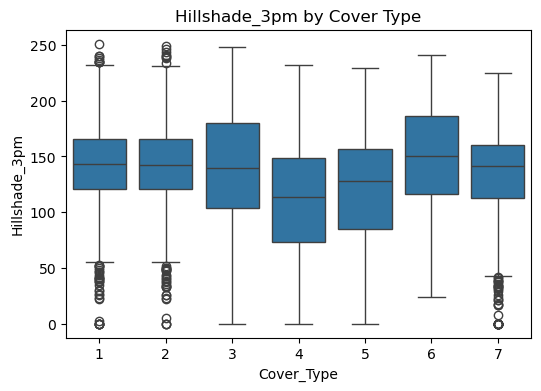

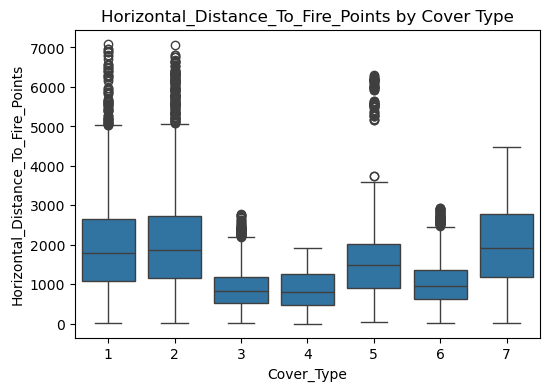

In [10]:
num_cols = train.loc[:, "Elevation":"Horizontal_Distance_To_Fire_Points"].columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=train, x="Cover_Type", y=col)
    plt.title(f"{col} by Cover Type")
    plt.show()

- All continuous columns have varying means per cover type.
- Some columns have less variation in means - maybe we could do a minimum threshold to prune features

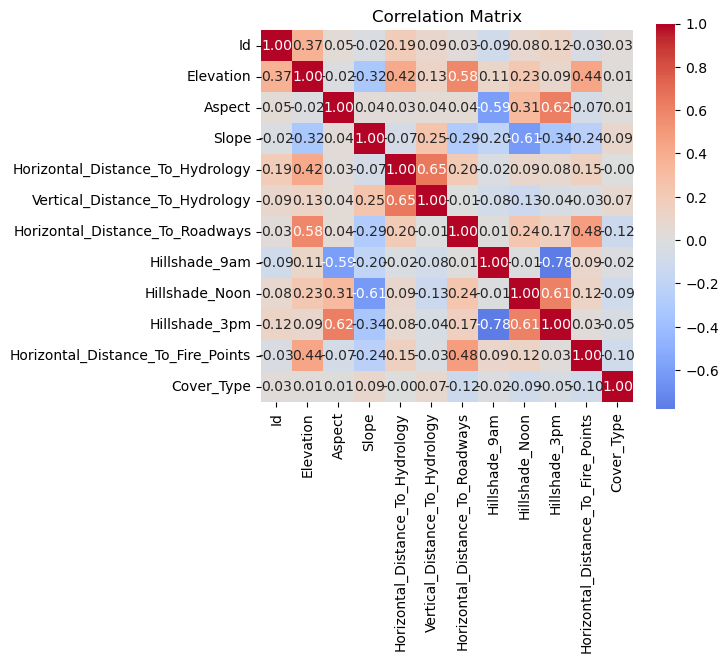

In [12]:
# Correlation heatmap
cat_cols = train.loc[:, "Wilderness_Area1":"Soil_Type40"].columns

corr_set = train.drop(columns=cat_cols)
corr = corr_set.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True
)

plt.title("Correlation Matrix")
plt.show()

Some relatively strong correlations, but none above 0.9

In [13]:

'''
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(
        data=train,
        x=col,
        hue="Cover_Type"
    )
    plt.title(col)
    plt.tight_layout()
    plt.show()
    '''


'\nfor col in cat_cols:\n    plt.figure(figsize=(6, 4))\n    sns.countplot(\n        data=train,\n        x=col,\n        hue="Cover_Type"\n    )\n    plt.title(col)\n    plt.tight_layout()\n    plt.show()\n    '

In [14]:
soil_types = [c for c in train.columns if c.startswith("Soil_Type")]
zero_soils = train[soil_types].columns[(train[soil_types] == 0).all()]
rare_soils = train[soil_types].mean().sort_values().head(10)

print(f'Soil types all zero: {zero_soils.tolist()} \n Soil types low frequency: {rare_soils}')

soils_to_remove = list(zero_soils) + list(rare_soils.index)


Soil types all zero: ['Soil_Type15'] 
 Soil types low frequency: Soil_Type15    0.000000
Soil_Type7     0.000066
Soil_Type8     0.000132
Soil_Type9     0.000265
Soil_Type25    0.000397
Soil_Type28    0.000463
Soil_Type27    0.000529
Soil_Type21    0.000661
Soil_Type36    0.000926
Soil_Type34    0.001190
dtype: float64


can remove some soil types

In [15]:
wilderness_areas = [c for c in train.columns if c.startswith("Wilderness_Area")]
train.groupby("Cover_Type")[wilderness_areas].mean().T

Cover_Type,1,2,3,4,5,6,7
Wilderness_Area1,0.494444,0.511574,0.000000,0.0,0.399074,0.000000,0.246759
Wilderness_Area2,0.109722,0.039352,0.000000,0.0,0.000000,0.000000,0.114352
Wilderness_Area3,0.395833,0.439352,0.396296,0.0,0.600926,0.446296,0.638889
Wilderness_Area4,0.000000,0.009722,0.603704,1.0,0.000000,0.553704,0.000000


wilderness areas are informative

## Model Selection

In [16]:
x_train = train.drop(columns=soils_to_remove + ['Cover_Type'])
y_train = train['Cover_Type']

# K-fold because balanced target
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [17]:
# Models
logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

In [18]:
scores_logreg = cross_validate(
    logreg,
    x_train,
    y_train,
    cv=kf,
    scoring={
        "acc": "accuracy",
        "f1": "f1_macro"
    }
)

scores_logreg["test_acc"].mean(), scores_logreg["test_f1"].mean()

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
   

(np.float64(0.40132275132275136), np.float64(0.3937077472349))

In [19]:
scores_rf = cross_validate(
    rf,
    x_train,
    y_train,
    cv=kf,
    scoring={
        "acc": "accuracy",
        "f1": "f1_macro"
    }
)

scores_rf["test_acc"].mean(), scores_rf["test_f1"].mean()

(np.float64(0.8880291005291007), np.float64(0.8862882663575707))

In [20]:
# OOF predictions
y_pred_logreg = cross_val_predict(
    logreg,
    x_train,
    y_train,
    cv=kf
)

y_pred_rf = cross_val_predict(
    rf,
    x_train,
    y_train,
    cv=kf
)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
   

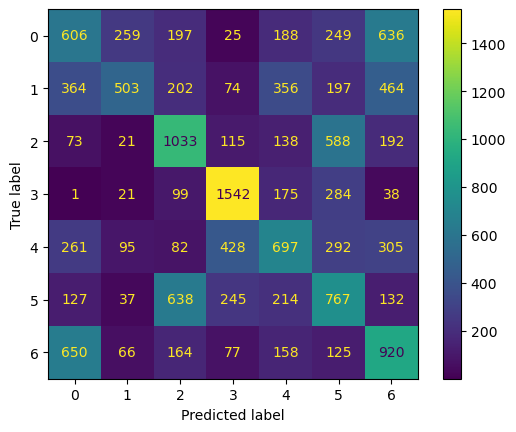

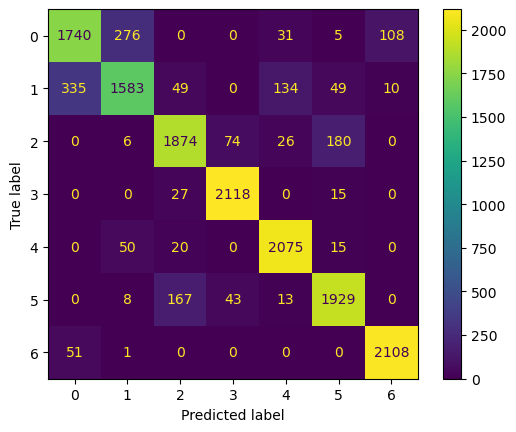

In [23]:
cm_logreg = confusion_matrix(y_train, y_pred_logreg)
cm_rf = confusion_matrix(y_train, y_pred_rf)

ConfusionMatrixDisplay(cm_logreg).plot()
ConfusionMatrixDisplay(cm_rf).plot()

Log reg shows confusion across the 6 classes, while randomforest is localized. Random forest is the model to be tuned. 

## Model Tuning

In [26]:
results = []

results.append({
    "Model": "Random Forest (baseline)",
    "Accuracy": baseline_acc,
    "Macro F1": baseline_f1
})

results_df = pd.DataFrame(results).round(4)
results_df

,Model,Accuracy,Macro F1
0,Random Forest (baseline),0.888,0.8863


In [35]:
# Grid Search

param_grid = {
    "max_depth": [None, 10, 25, 50],
    "min_samples_leaf": [1, 5, 10]
}

def run_grid(param_grid):
    grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=kf,
        scoring="f1_macro",
        n_jobs=-1
)
    grid.fit(x_train, y_train)
    return grid

grid =run_grid(param_grid)

# Params and score
best_params = grid.best_params_
best_score = grid.best_score_
best_model = grid.best_estimator_

print(best_params, best_score)

{'max_depth': 25, 'min_samples_leaf': 1} 0.8877669193350816


In [ ]:
# 2nd grid
param_grid2 = {
    "max_depth": [None, 20, 30, 40],
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", 0.5],
}

grid = run_grid(param_grid2)

# Params and score
best_params = grid.best_params_
best_score = grid.best_score_
best_model = grid.best_estimator_

print(best_params, best_score)

{'max_depth': 30, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.8876994896374907


Exception ignored in: <function ResourceTracker.__del__ at 0x104335bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x120659bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106689bc0>
Traceback (most recent call last

try boosting next, if improvement tune, if none settle